# Extrapolation: Savings Mid

### Importing Packages

In [2]:
import pandas as pd
import numpy as np

import patsy                           # provides a syntax for specifying models  
import statsmodels.api as sm           # provides statistical models like ols, gmm, anova, etc...
import statsmodels.formula.api as smf  # provides a way to directly spec models from formulas

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Importing Simulation and HVAC Data

In [3]:
# annual electricity cost saving ($) # annual natural gas cost saving ($) # annual energy cost saving ($)

In [4]:
# Import simulation data
simdata = pd.read_csv("MidPackage_RetrofitResults.csv")
# Import HVAC data
hvac = pd.read_csv("LA_HVAC_results.csv")
print('Pre-merge:','\n',simdata.shape, '\n', hvac.shape)

# Merge dataframes
merged = pd.merge(simdata, hvac, left_on="ubid", right_on="LA_bid")
print("Post-merge:","\n", merged.shape)
#merged.head()

# Selecting only buidlings from Simulation
merged = merged[merged['retrofit package name'] == "ECM Package 1"]

# Renaming some columns
merged = merged.rename(columns={"building type": "building_type", 
                                "year built (year)": "year_built", 
                                "total floor area (m2)": "floor_area", 
                                "baseline annual site energy use intensity (kWh/m2)": "site_eui",
                                "baseline annual water for water systems (m3/m2)": "annual_water",
                                "annual electricity cost saving ($)": "elec_cost_savings", 
                                "annual natural gas cost saving ($)": "gas_cost_savings",
                                "annual energy cost saving ($)": "energy_cost_savings" })

# Changing units
merged["annual_water"] = merged["annual_water"]*merged["floor_area"]
merged["annual_water"] = merged["annual_water"]*264.172
merged["floor_area"] = merged["floor_area"]*10.7639
merged["annual_water"] = merged["annual_water"]/merged["floor_area"]

Pre-merge: 
 (486, 105) 
 (243, 5)
Post-merge: 
 (486, 110)


### Importing EBEWE Data

In [5]:
EBEWE_buildings = pd.read_csv("Building_Data.csv") 
EBEWE_buildings = EBEWE_buildings.replace('Not Available',np.NaN)
EBEWE_buildings = EBEWE_buildings.replace('',np.NaN)
EBEWE_buildings = EBEWE_buildings.replace(' ',np.NaN)

# Keeping only unqiue buidling IDs
unique = EBEWE_buildings.drop_duplicates('BUILDING.ID') 

# Renaming some columns
unique = unique.rename(columns={"YEAR.BUILT": "year_built", 
                                "GROSS.BUILDING.FLOOR.AREA": "floor_area", 
                                "SITE.EUI": "site_eui",
                                "TOTAL.WATER.USE": "annual_water"})
# Changing units
unique["annual_water"] = (unique["annual_water"]*1000)/unique['floor_area']

unique.shape

(11724, 36)

## Savings

In [6]:
# Subset dataframe
merged_ht = merged[["elec_cost_savings","gas_cost_savings","energy_cost_savings",
                    "building_type","year_built","floor_area","site_eui", "annual_water"]]
# Reduce number of building types
merged_ht = merged_ht.replace({"Multi Family House": "multi_family",
                               "Medium Retail": "retail", 
                               "Small Retail" : "retail", 
                               "Large Office" : "office", 
                               "Medium Office": "office",
                               "Small Office" : "office"})

merged_ht = pd.get_dummies(merged_ht) 

print(merged_ht.describe())

# Get Year built indicators
merged_ht["pre1970"] = 0
merged_ht.loc[(merged_ht['year_built'] < 1970), 'pre1970'] = 1
merged_ht["in1970s"] = 0
merged_ht.loc[(merged_ht['year_built'] >= 1970) & (merged_ht['year_built'] < 1980), 'in1970s'] = 1
merged_ht["in1980s"] = 0
merged_ht.loc[(merged_ht['year_built'] >= 1980) & (merged_ht['year_built'] < 1990), 'in1980s'] = 1
merged_ht["post1990"] = 0
merged_ht.loc[(merged_ht['year_built'] > 1990), 'post1990'] = 1

# Scale contious variables
scaler = MinMaxScaler()
scaler.fit(merged_ht[["floor_area","site_eui","annual_water"]])
merged_ht[["floor_area","site_eui","annual_water"]] = scaler.transform(merged_ht[["floor_area","site_eui","annual_water"]])

#merged_ht.head()

       elec_cost_savings  gas_cost_savings  energy_cost_savings   year_built  \
count       2.430000e+02        243.000000         2.430000e+02   243.000000   
mean        1.009890e+05       3920.699959         1.049097e+05  1978.275720   
std         2.557815e+05       7429.640748         2.622328e+05     7.601796   
min        -6.608351e+04      -1673.750000        -6.368088e+04  1958.000000   
25%        -1.824695e+04        912.990000        -1.637647e+04  1972.000000   
50%         1.779313e+04       1516.080000         1.793622e+04  1978.000000   
75%         1.118659e+05       2420.980000         1.152924e+05  1984.000000   
max         1.904050e+06      52691.980000         1.941200e+06  1998.000000   

         floor_area    site_eui  annual_water  building_type_multi_family  \
count  2.430000e+02  243.000000    243.000000                  243.000000   
mean   1.813890e+05  148.086162     10.589004                    0.485597   
std    2.369338e+05   66.897671      8.867928   

## Regression Models

##### Regression model for annual electricity cost saving

In [7]:
# Base model
formula1 = 'elec_cost_savings ~ floor_area + np.power(floor_area,2) + site_eui  + annual_water + building_type_multi_family + building_type_office + building_type_retail + pre1970 + in1970s + in1980s + post1990 -1'
res1 = smf.ols(formula1, data=merged_ht).fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:      elec_cost_savings   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     442.3
Date:                Tue, 13 Apr 2021   Prob (F-statistic):          5.51e-145
Time:                        15:48:25   Log-Likelihood:                -3005.8
No. Observations:                 243   AIC:                             6034.
Df Residuals:                     232   BIC:                             6072.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
floor_area          

In [8]:
# Improved model
formula2 = 'elec_cost_savings ~ floor_area + np.power(floor_area,2) + site_eui -1'
elec_res = smf.ols(formula2, data=merged_ht).fit()
print(elec_res.summary())

                                 OLS Regression Results                                
Dep. Variable:      elec_cost_savings   R-squared (uncentered):                   0.886
Model:                            OLS   Adj. R-squared (uncentered):              0.885
Method:                 Least Squares   F-statistic:                              624.5
Date:                Tue, 13 Apr 2021   Prob (F-statistic):                   4.96e-113
Time:                        15:48:25   Log-Likelihood:                         -3123.5
No. Observations:                 243   AIC:                                      6253.
Df Residuals:                     240   BIC:                                      6264.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

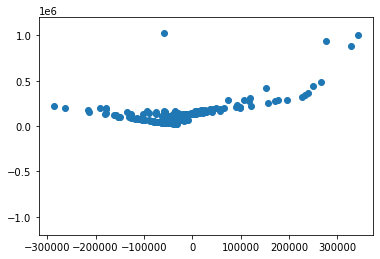

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.scatter(elec_res.resid, elec_res.fittedvalues)
ax.set_ylim([-1200000,1200000])
plt.show()

##### Regression model for annual natural gas cost saving 

In [10]:
# Base model
formula3 = 'gas_cost_savings ~ floor_area + np.power(floor_area,2) + site_eui  + annual_water + building_type_multi_family + building_type_office + building_type_retail + pre1970 + in1970s + in1980s + post1990 -1'
res3 = smf.ols(formula3, data=merged_ht).fit()
print(res3.summary())

                            OLS Regression Results                            
Dep. Variable:       gas_cost_savings   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     80.45
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           1.17e-69
Time:                        15:48:25   Log-Likelihood:                -2328.3
No. Observations:                 243   AIC:                             4679.
Df Residuals:                     232   BIC:                             4717.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
floor_area          

In [11]:
# Improved model
formula4 = 'gas_cost_savings ~ floor_area + np.power(floor_area,2) + site_eui -1'
gas_res = smf.ols(formula4, data=merged_ht).fit()
print(gas_res.summary())

                                 OLS Regression Results                                
Dep. Variable:       gas_cost_savings   R-squared (uncentered):                   0.734
Model:                            OLS   Adj. R-squared (uncentered):              0.731
Method:                 Least Squares   F-statistic:                              220.9
Date:                Tue, 13 Apr 2021   Prob (F-statistic):                    9.56e-69
Time:                        15:48:25   Log-Likelihood:                         -2379.2
No. Observations:                 243   AIC:                                      4764.
Df Residuals:                     240   BIC:                                      4775.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

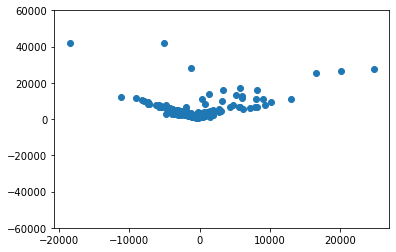

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.scatter(gas_res.resid, gas_res.fittedvalues)
ax.set_ylim([-60000,60000])
plt.show()

##### Regression model for annual energy cost saving

In [13]:
# Base model
formula5 = 'energy_cost_savings ~ floor_area + np.power(floor_area,2) + site_eui  + annual_water + building_type_multi_family + building_type_office + building_type_retail + pre1970 + in1970s + in1980s + post1990 -1'
res5 = smf.ols(formula5, data=merged_ht).fit()
print(res5.summary())

                             OLS Regression Results                            
Dep. Variable:     energy_cost_savings   R-squared:                       0.949
Model:                             OLS   Adj. R-squared:                  0.946
Method:                  Least Squares   F-statistic:                     428.2
Date:                 Tue, 13 Apr 2021   Prob (F-statistic):          1.97e-143
Time:                         15:48:25   Log-Likelihood:                -3015.6
No. Observations:                  243   AIC:                             6053.
Df Residuals:                      232   BIC:                             6092.
Df Model:                           10                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
floor_area

In [14]:
# Improved model
formula6 = 'energy_cost_savings ~ floor_area + np.power(floor_area,2) + site_eui -1'
energy_res = smf.ols(formula6, data=merged_ht).fit()
print(energy_res.summary())

                                 OLS Regression Results                                 
Dep. Variable:     energy_cost_savings   R-squared (uncentered):                   0.885
Model:                             OLS   Adj. R-squared (uncentered):              0.884
Method:                  Least Squares   F-statistic:                              617.0
Date:                 Tue, 13 Apr 2021   Prob (F-statistic):                   1.77e-112
Time:                         15:48:25   Log-Likelihood:                         -3131.3
No. Observations:                  243   AIC:                                      6269.
Df Residuals:                      240   BIC:                                      6279.
Df Model:                            3                                                  
Covariance Type:             nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------

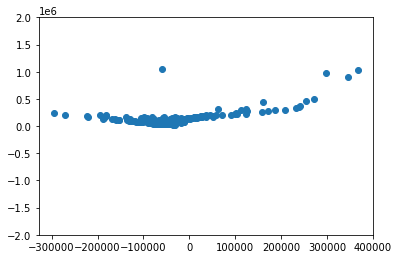

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.scatter(energy_res.resid, energy_res.fittedvalues)
ax.set_ylim([-2000000,2000000])
plt.show()

## Extrapolation to EBEWE Data

In [16]:
# Select only medium multi-family 
e_allthree = unique[(unique["PROPERTY.TYPE"]=="Multifamily Housing") | 
                    (unique["PROPERTY.TYPE"]=="Office") | 
                    (unique["PROPERTY.TYPE"]=="Retail Store")]

e_allthree = e_allthree.replace({"Multifamily Housing": "multi_family",
                                 "Office": "office", 
                                 "Retail Store" : "retail"})

e_allthree = e_allthree[["BUILDING.ID", "PROPERTY.TYPE", "year_built", "floor_area", "site_eui"]]
e_allthree = e_allthree.rename(columns={"PROPERTY.TYPE": "building_type"})

e_allthree = pd.get_dummies(e_allthree) 
                                        
e_allthree["pre1970"] = 0
e_allthree.loc[(e_allthree['year_built'] < 1970), 'pre1970'] = 1
e_allthree["in1970s"] = 0
e_allthree.loc[(e_allthree['year_built'] >= 1970) & (e_allthree['year_built'] < 1980), 'in1970s'] = 1
e_allthree["in1980s"] = 0
e_allthree.loc[(e_allthree['year_built'] >= 1980) & (e_allthree['year_built'] < 1990), 'in1980s'] = 1
e_allthree["post1990"] = 0
e_allthree.loc[(e_allthree['year_built'] > 1990), 'post1990'] = 1


#e_allthree["building_type_medium_office"] = 0
#e_allthree.loc[(e_allthree['building_type_office'] == 1) & 
#               (e_allthree['floor_area'] < 100000), 'building_type_medium_office'] = 1
#e_allthree["building_type_large_office"] = 0
#e_allthree.loc[(e_allthree['building_type_office'] == 1) & 
#               (e_allthree['floor_area'] > 100000), 'building_type_large_office'] = 1

#e_allthree["building_type_small_retail"] = 0
#e_allthree.loc[(e_allthree['building_type_retail'] == 1) & 
#               (e_allthree['floor_area'] < 50000), 'building_type_small_retail'] = 1
#e_allthree["building_type_medium_retail"] = 0
#e_allthree.loc[(e_allthree['building_type_retail'] == 1) & 
#               (e_allthree['floor_area'] > 500000), 'building_type_large_office'] = 1
                
scaler = MinMaxScaler()
scaler.fit(e_allthree[["floor_area","site_eui"]])
e_allthree[["floor_area","site_eui"]] = scaler.transform(e_allthree[["floor_area","site_eui"]])

e_allthree = e_allthree.dropna()

In [17]:
# Making copies of for all three metrics
e_allthree1 = e_allthree.copy()
e_allthree2 = e_allthree.copy()
e_allthree3 = e_allthree.copy()

# Extrapolating the three saving metrics using EBEWE data
e_allthree1['MID_pred_elec_savings'] = elec_res.predict(e_allthree1[['floor_area', 'site_eui', 'building_type_multi_family',
       'building_type_office', 'building_type_retail', 'pre1970', 'in1970s', 'in1980s', 'post1990']])
e_allthree2['MID_pred_gas_savings'] = gas_res.predict(e_allthree2[['floor_area', 'site_eui', 'building_type_multi_family',
       'building_type_office', 'building_type_retail', 'pre1970', 'in1970s', 'in1980s', 'post1990']])
e_allthree3['MID_pred_energy_savings'] = energy_res.predict(e_allthree3[['floor_area', 'site_eui', 'building_type_multi_family',
       'building_type_office', 'building_type_retail', 'pre1970', 'in1970s', 'in1980s', 'post1990']])

In [18]:
# Subsetting only relevant information
mid_data1 = e_allthree1[["BUILDING.ID", "MID_pred_elec_savings"]]
mid_data2 = e_allthree2[["BUILDING.ID", "MID_pred_gas_savings"]]
mid_data3 = e_allthree3[["BUILDING.ID", "MID_pred_energy_savings"]]

# Combining all three saving metrics
mid_savings_data = pd.concat([mid_data1,mid_data2["MID_pred_gas_savings"],mid_data3["MID_pred_energy_savings"]], axis=1)

In [19]:
mid_savings_data.describe()

,BUILDING.ID,MID_pred_elec_savings,MID_pred_gas_savings,MID_pred_energy_savings
count,2.628000e+03,2.628000e+03,2628.000000,2.628000e+03
mean,4.477590e+11,1.119456e+04,958.224290,1.215279e+04
std,9.638100e+10,5.734808e+04,1783.406985,5.893390e+04
min,6.170000e+02,3.812150e+02,53.774661,4.349896e+02
25%,4.227831e+11,2.325700e+03,308.020981,2.636857e+03
50%,4.457198e+11,3.610552e+03,471.064471,4.081940e+03
75%,4.709843e+11,7.508272e+03,919.948534,8.434040e+03
max,9.990000e+11,1.969891e+06,40562.587807,2.010453e+06


## Merging with Final Dataset

In [21]:
final_data

,LADBS_ID,Address,Postal_Code,EBEWE_Compliance_Wave,EBEWE_Compliance_Date,Property_Type,Year_Built,Building_SQFT,LADBS_Building_Category,City_Owned,...,Total_Water_Use,Predicted_HVAC_Capacity_Tonnage_per_Unit,Predicted_HVAC_Units,Predicted_HVAC_Type,Predicted_Investment_Cost,Predicted_Energy_Cost_Savings,Predicted_Elecricity_Cost_Savings,Predicted_Natural_Gas_Cost_Savings,Predicted_Natural_Gas_Usage,Predicted_kwAmount
0,617,117 S BOYLE AVE,90033,4,"December 1, 2024",Multifamily Housing,2016.0,90684.0,"50,000 to 99,999",No,...,3402.1,0.282959,16.0,4.0,31927.426606,842.951851,502.655456,340.297025,NaN,NaN
1,1192,13337 W BEACH AVE,90292,2,"December 1, 2022",NaN,NaN,NaN,"50,000 to 99,999",No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1938,901 W OLYMPIC BLVD,90015,5,"December 1, 2025",Hotel,2014.0,295750.0,"100,000+",No,...,11188.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2360,12582 W MILLENNIUM,90094,1,"December 1, 2021",NaN,NaN,NaN,"50,000 to 99,999",No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2942,13055 W ARROYO ST,91340,2,"December 1, 2022",NaN,NaN,NaN,"50,000 to 99,999",No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11719,999000000490,12636 BEATRICE ST,90066,1,"December 1, 2021",Mixed Use Property,1976.0,50000.0,"20,000 to 49,999",No,...,208.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11720,999000000494,5550 WILSHIRE BLVD,90036,3,"December 1, 2023",Multifamily Housing,2010.0,231034.0,"100,000+",No,...,9717.2,0.869052,38.0,4.0,61749.160219,1733.181465,1103.353694,629.829042,NaN,NaN
11721,999000000495,939 S HILL ST,90015,3,"December 1, 2023",Multifamily Housing,2015.0,238932.0,"100,000+",No,...,7603.0,0.598395,39.0,4.0,63139.395582,1578.596000,1050.821066,527.776712,NaN,NaN
11722,999000000496,770 S GRAND AVE,90017,4,"December 1, 2024",Multifamily Housing,2015.0,70000.0,"100,000+",No,...,20.8,6.927765,12.0,4.0,31919.827764,2308.570406,1086.654466,1221.912269,NaN,NaN


In [30]:
# Import final dataset
final_data = pd.read_csv("Final_Dataset.csv")
print('Pre-merge:','\n',final_data.shape, '\n', mid_savings_data.shape)

# Merge dataframes
final_data = pd.merge(final_data, mid_savings_data, left_on="LADBS_ID", right_on="BUILDING.ID", how="outer")
final_data.drop(columns=["BUILDING.ID"], inplace=True)
print("Post-merge:","\n", final_data.shape)

Pre-merge: 
 (11724, 31) 
 (2628, 4)
Post-merge: 
 (11724, 34)


In [32]:
final_data.to_csv("Final_Dataset_v2.csv", index=False)